<a href="https://colab.research.google.com/github/PrswpkWirom/Depression-Detection-FinalProject/blob/main/DD_vanilla_MFFNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataloader, mini batch

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import pickle
from google.colab import files
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
pickle_file_path = '/content/drive/MyDrive/DD_input_text_tensor_cpu.pkl'
input_text_tensor = torch.load(pickle_file_path)
print(input_text_tensor)


<ipython-input-2-1ce23ae293e7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_text_tensor = torch.load(pickle_file_path)


tensor([[[-0.0584,  0.0803, -0.0016,  ..., -0.0751, -0.0839, -0.0127],
         [-0.0734,  0.0904,  0.0002,  ..., -0.0699, -0.0782, -0.0195],
         [-0.0787,  0.0642, -0.0052,  ..., -0.0863, -0.0811, -0.0373],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.0524,  0.0920, -0.0036,  ..., -0.0810, -0.0577, -0.0343],
         [-0.0517,  0.0909, -0.0059,  ..., -0.0802, -0.0536, -0.0325],
         [-0.0736,  0.0564,  0.0038,  ..., -0.1028, -0.0545, -0.0117],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.0596,  0.1051,  0.0067,  ..., -0.0871, -0.0634, -0.0286],
         [-0.0597,  0.0772, -0.0034,  ..., -0

In [ ]:
print(input_text_tensor.shape)

torch.Size([10, 169, 768])


In [ ]:
pickle_file_path = '/content/drive/MyDrive/DD_input_audio_tensor_cpu.pkl'
input_audio_tensor = torch.load(pickle_file_path)
print(input_audio_tensor)

<ipython-input-4-a07edf880e79>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_audio_tensor = torch.load(pickle_file_path)


tensor([[[ 2.9665e-02,  1.0969e-02, -1.3585e-01,  ...,  1.5336e-01,
          -6.4800e-02, -1.2271e-01],
         [-1.2926e-01,  6.6667e-02,  5.7625e-02,  ..., -9.6505e-02,
          -3.8745e-02, -6.6007e-02],
         [-2.2797e-01,  2.4531e-02, -3.4593e-01,  ...,  2.6354e-02,
          -5.2208e-03,  7.0064e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-3.6057e-02, -4.6827e-01, -3.0396e-01,  ..., -1.4735e-03,
          -2.0177e-01,  2.6604e-01],
         [ 2.9317e-02, -9.1001e-02, -2.2257e-01,  ...,  2.9565e-01,
           2.8292e-01,  4.7135e-02],
         [-4.0544e-02, -1.4174e-01, -2.1277e-01,  ...,  1.6574e-01,
           7.5368e-02, -1.2303e-02],
         ...,
         [ 0.0000e+00,  0

In [ ]:
print(input_audio_tensor.shape)

torch.Size([10, 169, 768])


# Fastformer Implementation

This fastformer module is obtained from github: https://github.com/wuch15/Fastformer

In [ ]:
from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertSelfOutput, BertIntermediate, BertOutput
class AttentionPooling(nn.Module):
    def __init__(self, config):
        self.config = config
        super(AttentionPooling, self).__init__()
        self.att_fc1 = nn.Linear(config.hidden_size, config.hidden_size)
        self.att_fc2 = nn.Linear(config.hidden_size, 1)
        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()


    def forward(self, x, attn_mask=None):
        bz = x.shape[0]
        e = self.att_fc1(x)
        e = nn.Tanh()(e)
        alpha = self.att_fc2(e)
        alpha = torch.exp(alpha)
        if attn_mask is not None:
            alpha = alpha * attn_mask.unsqueeze(2)
        alpha = alpha / (torch.sum(alpha, dim=1, keepdim=True) + 1e-8)
        x = torch.bmm(x.permute(0, 2, 1), alpha)
        x = torch.reshape(x, (bz, -1))
        return x

class FastSelfAttention(nn.Module):
    def __init__(self, config):
        super(FastSelfAttention, self).__init__()
        self.config = config
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" %
                (config.hidden_size, config.num_attention_heads))
        self.attention_head_size = int(config.hidden_size /config.num_attention_heads)
        self.num_attention_heads = config.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.input_dim= config.hidden_size

        self.query = nn.Linear(self.input_dim, self.all_head_size)
        self.query_att = nn.Linear(self.all_head_size, self.num_attention_heads)
        self.key = nn.Linear(self.input_dim, self.all_head_size)
        self.key_att = nn.Linear(self.all_head_size, self.num_attention_heads)
        self.transform = nn.Linear(self.all_head_size, self.all_head_size)

        self.softmax = nn.Softmax(dim=-1)

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads,
                                       self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask):
        # batch_size, seq_len, num_head * head_dim, batch_size, seq_len
        batch_size, seq_len, _ = hidden_states.shape
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        # batch_size, num_head, seq_len
        query_for_score = self.query_att(mixed_query_layer).transpose(1, 2) / self.attention_head_size**0.5
        # add attention mask
        query_for_score += attention_mask

        # batch_size, num_head, 1, seq_len
        query_weight = self.softmax(query_for_score).unsqueeze(2)

        # batch_size, num_head, seq_len, head_dim
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # batch_size, num_head, head_dim, 1
        pooled_query = torch.matmul(query_weight, query_layer).transpose(1, 2).view(-1,1,self.num_attention_heads*self.attention_head_size)
        pooled_query_repeat= pooled_query.repeat(1, seq_len,1)
        # batch_size, num_head, seq_len, head_dim

        # batch_size, num_head, seq_len
        mixed_query_key_layer=mixed_key_layer* pooled_query_repeat

        query_key_score=(self.key_att(mixed_query_key_layer)/ self.attention_head_size**0.5).transpose(1, 2)

        # add attention mask
        query_key_score +=attention_mask

        # batch_size, num_head, 1, seq_len
        query_key_weight = self.softmax(query_key_score).unsqueeze(2)

        key_layer = self.transpose_for_scores(mixed_query_key_layer)
        pooled_key = torch.matmul(query_key_weight, key_layer)

        #query = value
        weighted_value =(pooled_key * query_layer).transpose(1, 2)
        weighted_value = weighted_value.reshape(
            weighted_value.size()[:-2] + (self.num_attention_heads * self.attention_head_size,))
        weighted_value = self.transform(weighted_value) + mixed_query_layer

        return weighted_value


class FastAttention(nn.Module):
    def __init__(self, config):
        super(FastAttention, self).__init__()
        self.self = FastSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask):
        self_output = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output

class FastformerLayer(nn.Module):
    def __init__(self, config):
        super(FastformerLayer, self).__init__()
        self.attention = FastAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

class FastformerEncoder(nn.Module):
    def __init__(self, config, pooler_count=1):
        super(FastformerEncoder, self).__init__()
        self.config = config
        self.encoders = nn.ModuleList([FastformerLayer(config) for _ in range(config.num_hidden_layers)])
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # support multiple different poolers with shared bert encoder.
        self.poolers = nn.ModuleList()
        if config.pooler_type == 'weightpooler':
            for _ in range(pooler_count):
                self.poolers.append(AttentionPooling(config))
        logging.info(f"This model has {len(self.poolers)} poolers.")

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if isinstance(module, (nn.Embedding)) and module.padding_idx is not None:
                with torch.no_grad():
                    module.weight[module.padding_idx].fill_(0)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self,
                input_embs,
                attention_mask,
                pooler_index=0):
        #input_embs: batch_size, seq_len, emb_dim
        #attention_mask: batch_size, seq_len, emb_dim

        extended_attention_mask = attention_mask.unsqueeze(1)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        batch_size, seq_length, emb_dim = input_embs.shape
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_embs.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)
        position_embeddings = self.position_embeddings(position_ids)

        embeddings = input_embs + position_embeddings

        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        #print(embeddings.size())
        all_hidden_states = [embeddings]

        for i, layer_module in enumerate(self.encoders):
            layer_outputs = layer_module(all_hidden_states[-1], extended_attention_mask)
            all_hidden_states.append(layer_outputs)
        assert len(self.poolers) > pooler_index
        output = self.poolers[pooler_index](all_hidden_states[-1], attention_mask)

        return output

class Model(torch.nn.Module):

    def __init__(self,config):
        super(Model, self).__init__()
        self.config = config
        self.dense_linear = nn.Linear(config.hidden_size,4)
        self.word_embedding = nn.Embedding(len(word_dict),256,padding_idx=0)
        self.fastformer_model = FastformerEncoder(config)
        self.criterion = nn.CrossEntropyLoss()
        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if isinstance(module, (nn.Embedding)) and module.padding_idx is not None:
                with torch.no_grad():
                    module.weight[module.padding_idx].fill_(0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self,input_ids,targets):
        mask=input_ids.bool().float()
        embds=self.word_embedding(input_ids)
        text_vec = self.fastformer_model(embds,mask)
        score = self.dense_linear(text_vec)
        loss = self.criterion(score, targets)
        return loss, score

def acc(y_true, y_hat):
    y_hat = torch.argmax(y_hat, dim=-1)
    tot = y_true.shape[0]
    hit = torch.sum(y_true == y_hat)
    return hit.data.float() * 1.0 / tot

# Vanilla MSFastformer: Attempt 1

In [ ]:
# class AttentionPooling(nn.Module):
#     def __init__(self, config):
#         super(AttentionPooling, self).__init__()
#         self.config = config
#         self.att_fc1 = nn.Linear(config.hidden_size, config.hidden_size)
#         self.att_fc2 = nn.Linear(config.hidden_size, 1)
#         self.apply(self.init_weights)

#     def init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()

#     def forward(self, x, attn_mask=None):
#         bz = x.shape[0]
#         e = self.att_fc1(x)
#         e = nn.Tanh()(e)
#         alpha = self.att_fc2(e)
#         alpha = torch.exp(alpha)
#         if attn_mask is not None:
#             alpha = alpha * attn_mask.unsqueeze(2)
#         alpha = alpha / (torch.sum(alpha, dim=1, keepdim=True) + 1e-8)
#         x = torch.bmm(x.permute(0, 2, 1), alpha)
#         x = x.reshape(bz, -1)
#         return x

# class FastSelfAttention(nn.Module):
#     def __init__(self, config):
#         super(FastSelfAttention, self).__init__()
#         self.config = config
#         if config.hidden_size % config.num_attention_heads != 0:
#             raise ValueError(
#                 "The hidden size (%d) is not a multiple of the number of attention "
#                 "heads (%d)" %
#                 (config.hidden_size, config.num_attention_heads))
#         self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
#         self.num_attention_heads = config.num_attention_heads
#         self.all_head_size = self.num_attention_heads * self.attention_head_size

#         self.query = nn.Linear(config.hidden_size, self.all_head_size)
#         self.query_att = nn.Linear(self.all_head_size, self.num_attention_heads)
#         self.key = nn.Linear(config.hidden_size, self.all_head_size)
#         self.key_att = nn.Linear(self.all_head_size, self.num_attention_heads)
#         self.transform = nn.Linear(self.all_head_size, self.all_head_size)
#         self.softmax = nn.Softmax(dim=-1)

#         self.apply(self.init_weights)

#     def init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()

#     def transpose_for_scores(self, x):
#         new_x_shape = x.size()[:-1] + (self.num_attention_heads,
#                                        self.attention_head_size)
#         x = x.view(*new_x_shape)
#         return x.permute(0, 2, 1, 3)

#     def forward(self, q_input, k_input, attention_mask=None):
#         batch_size, seq_len, _ = q_input.shape
#         # Project queries and keys
#         mixed_query_layer = self.query(q_input)
#         mixed_key_layer = self.key(k_input)

#         # Compute query scores
#         query_for_score = self.query_att(mixed_query_layer).transpose(1, 2) / self.attention_head_size**0.5
#         if attention_mask is not None:
#             query_for_score = query_for_score + attention_mask

#         query_weight = self.softmax(query_for_score).unsqueeze(2)
#         query_layer = self.transpose_for_scores(mixed_query_layer)

#         pooled_query = torch.matmul(query_weight, query_layer).transpose(1, 2).reshape(
#             batch_size, 1, self.all_head_size)
#         pooled_query_repeat = pooled_query.repeat(1, seq_len, 1)

#         # Modulate keys with pooled queries
#         mixed_query_key_layer = mixed_key_layer * pooled_query_repeat

#         # Compute key scores
#         query_key_score = (self.key_att(mixed_query_key_layer) / self.attention_head_size**0.5).transpose(1, 2)
#         if attention_mask is not None:
#             query_key_score = query_key_score + attention_mask

#         query_key_weight = self.softmax(query_key_score).unsqueeze(2)
#         key_layer = self.transpose_for_scores(mixed_query_key_layer)
#         pooled_key = torch.matmul(query_key_weight, key_layer)

#         # Compute final attention output
#         weighted_value = (pooled_key * query_layer).transpose(1, 2)
#         weighted_value = weighted_value.reshape(
#             weighted_value.size()[:-2] + (self.num_attention_heads * self.attention_head_size,))
#         attention_output = self.transform(weighted_value) + mixed_query_layer

#         return attention_output

# class FastAttention(nn.Module):
#     def __init__(self, config):
#         super(FastAttention, self).__init__()
#         self.self = FastSelfAttention(config)
#         self.output = nn.Identity()  # Replace BertSelfOutput with Identity for simplicity

#     def forward(self, input_tensor, attention_mask):
#         self_output = self.self(input_tensor, attention_mask)
#         attention_output = self.output(self_output)  # Assuming residual connection is handled elsewhere
#         return attention_output

# class FastformerLayer(nn.Module):
#     def __init__(self, config):
#         super(FastformerLayer, self).__init__()
#         self.attention = FastAttention(config)
#         self.intermediate = nn.Linear(config.hidden_size, config.intermediate_size)
#         self.output = nn.Linear(config.intermediate_size, config.hidden_size)
#         self.LayerNorm1 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
#         self.LayerNorm2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
#         self.dropout = nn.Dropout(config.hidden_dropout_prob)
#         self.activation = nn.GELU()

#     def forward(self, hidden_states, attention_mask):
#         attention_output = self.attention(hidden_states, attention_mask)
#         attention_output = self.dropout(attention_output)
#         attention_output = self.LayerNorm1(hidden_states + attention_output)

#         intermediate_output = self.intermediate(attention_output)
#         intermediate_output = self.activation(intermediate_output)

#         layer_output = self.output(intermediate_output)
#         layer_output = self.dropout(layer_output)
#         layer_output = self.LayerNorm2(attention_output + layer_output)

#         return layer_output

# class FastformerEncoder(nn.Module):
#     def __init__(self, config):
#         super(FastformerEncoder, self).__init__()
#         self.config = config
#         self.encoders = nn.ModuleList([FastformerLayer(config) for _ in range(config.num_hidden_layers)])
#         self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
#         self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
#         self.dropout = nn.Dropout(config.hidden_dropout_prob)

#         self.apply(self.init_weights)

#     def init_weights(self, module):
#         if isinstance(module, (nn.Linear, nn.Embedding)):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if isinstance(module, nn.Embedding) and module.padding_idx is not None:
#                 with torch.no_grad():
#                     module.weight[module.padding_idx].fill_(0)
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
#         if isinstance(module, nn.Linear) and module.bias is not None:
#             module.bias.data.zero_()

#     def forward(self, input_embs, attention_mask):
#         batch_size, seq_length, emb_dim = input_embs.shape
#         position_ids = torch.arange(seq_length, dtype=torch.long, device=input_embs.device)
#         position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)
#         position_embeddings = self.position_embeddings(position_ids)

#         embeddings = input_embs + position_embeddings
#         embeddings = self.LayerNorm(embeddings)
#         embeddings = self.dropout(embeddings)

#         extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
#         extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
#         extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

#         hidden_states = embeddings
#         for layer_module in self.encoders:
#             hidden_states = layer_module(hidden_states, extended_attention_mask)

#         return hidden_states




In [ ]:
# class CustomModel(nn.Module):
#     def __init__(self, config):
#         super(CustomModel, self).__init__()
#         self.config = config
#         self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
#         self.fastformer = FastSelfAttention(config)
#         self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
#         self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
#         self.output_fc = nn.Linear(config.hidden_size, config.num_labels)
#         self.gelu = nn.GELU()
#         self.apply(self.init_weights)

#     def init_weights(self, module):
#         if isinstance(module, (nn.Linear)):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)

#     def compute_covariance(self, x):
#         # x: [batch_size, seq_len, hidden_size]
#         batch_size, seq_len, hidden_size = x.size()
#         x_centered = x - x.mean(dim=1, keepdim=True)
#         covariance = torch.bmm(x_centered.transpose(1, 2), x_centered) / (seq_len - 1 + 1e-5)
#         # Reshape to [batch_size, 1, hidden_size]
#         covariance = covariance.mean(dim=2, keepdim=True).permute(0, 2, 1)
#         return covariance  # [batch_size, 1, hidden_size]

#     def forward(self, x, attention_mask):
#         # x: [batch_size, seq_len, embedding_dim]
#         batch_size, seq_len, _ = x.size()

#         # Normalize x
#         x_norm = self.layernorm(x)

#         # Compute U_i for i = 1, 3, 5
#         U_indices = [1, 3, 5]
#         U_list = []
#         for i in U_indices:
#             if i <= seq_len:
#                 U_i = self.compute_covariance(x_norm[:, :i, :])
#             else:
#                 U_i = self.compute_covariance(x_norm)
#             U_list.append(U_i)

#         U1, U3, U5 = U_list

#         # Prepare attention mask
#         extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=x.dtype)
#         extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

#         # Compute P
#         P1 = self.fastformer(U5, U3, extended_attention_mask)
#         P2 = self.fastformer(U3, U1, extended_attention_mask)
#         P3 = self.fastformer(U1, U5, extended_attention_mask)
#         P = P1 + P2 + P3
#         P_norm = self.layernorm(P)

#         # Compute I = FC(GELU(FC(Norm(P))))
#         I = self.fc2(self.gelu(self.fc1(P_norm)))

#         # Compute J = I + X
#         seq_len_I = I.size(1)
#         J = I + x[:, :seq_len_I, :]

#         # Final output y = FC(Norm(J))
#         J_norm = self.layernorm(J)
#         y = self.output_fc(J_norm)
#         y = y.mean(dim=1)  # Aggregate over sequence length

#         return y

# # Example usage:
# # Assuming you have input embeddings x of shape [batch_size, seq_len, embedding_dim]

# batch_size = 10
# sequence_length = 169  # Adjust as needed
# embedding_dim = 768

# # Create random input embeddings
# x = torch.randn(batch_size, sequence_length, embedding_dim)

# # Create attention mask
# attention_mask = torch.ones(batch_size, sequence_length)

# # Instantiate the configuration
# class Config:
#     def __init__(self):
#         self.hidden_size = 768
#         self.num_attention_heads = 12
#         self.num_hidden_layers = 12
#         self.intermediate_size = 3072
#         self.hidden_dropout_prob = 0.1
#         self.layer_norm_eps = 1e-12
#         self.initializer_range = 0.02
#         self.num_labels = 4
#         self.max_position_embeddings = 512
#         self.pooler_type = 'weightpooler'

# config = Config()

In [ ]:
# batch_size = 10
# sequence_length = 1  # Adjust as needed
# embedding_dim = config.hidden_size

# x = input_text_tensor

# # Create attention mask
# attention_mask = torch.ones(batch_size, sequence_length)

# # Instantiate the model
# model = CustomModel(config)

# # Forward pass
# output = model(x, attention_mask)

# print("Output shape:", output.shape)  # Should be [batch_size, num_labels]

RuntimeError: shape '[10, 1, 768]' is invalid for input of size 921600

# Vanilla MSFastformer: Attempt 2 (completed)

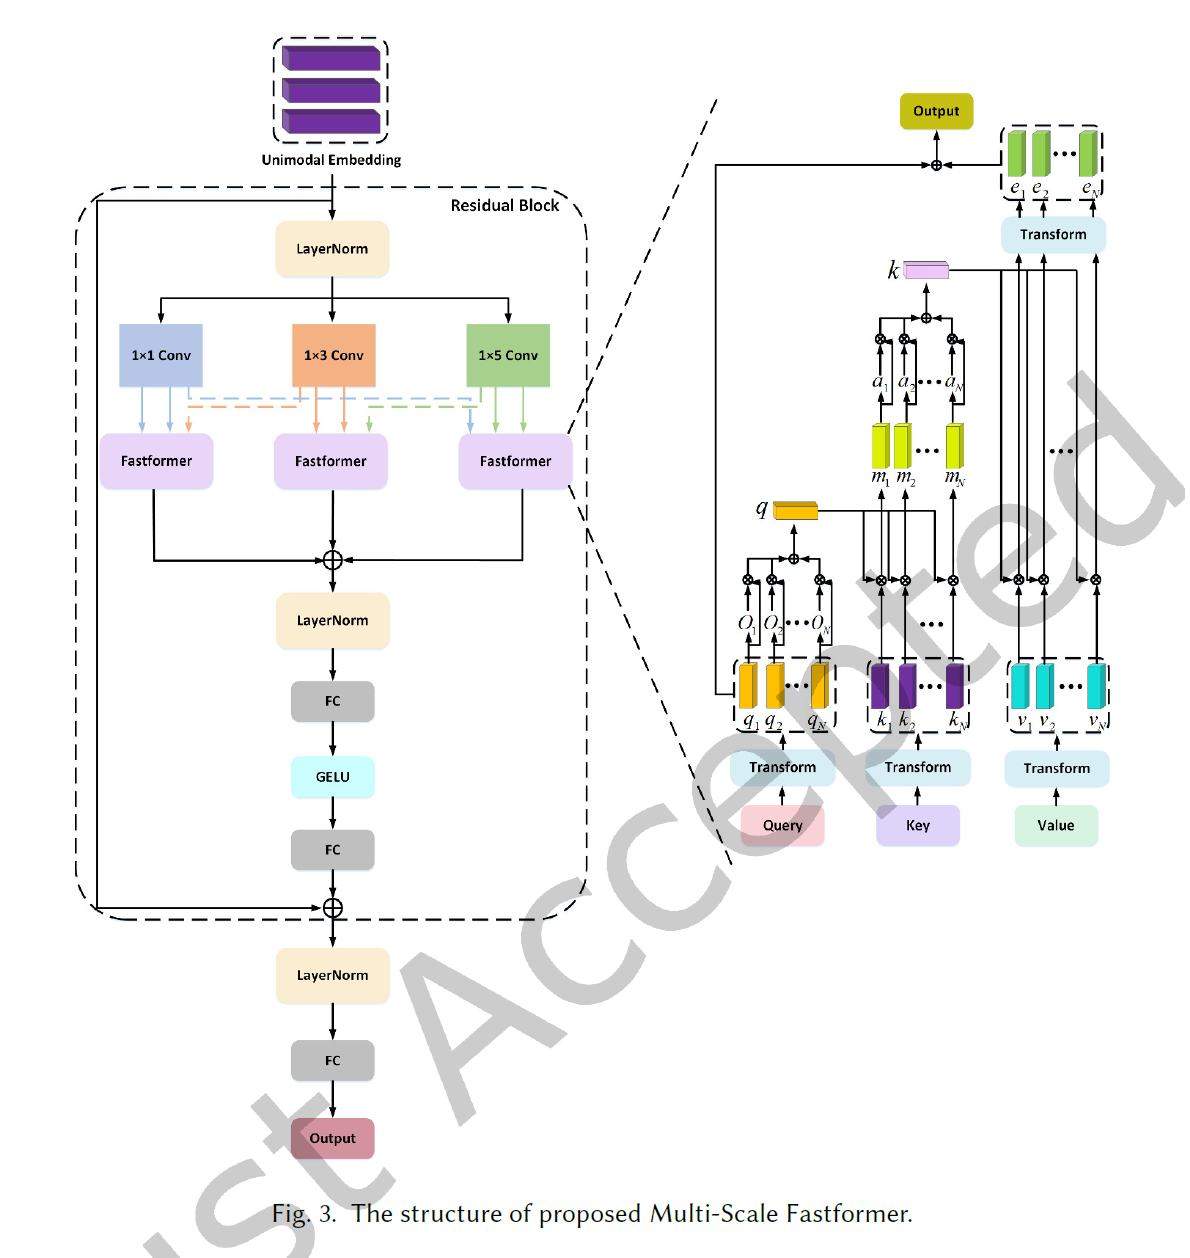

In [ ]:
class FastSelfAttention(nn.Module):
    def __init__(self, config):
        super(FastSelfAttention, self).__init__()
        self.config = config
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" %
                (config.hidden_size, config.num_attention_heads))
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.num_attention_heads = config.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.input_dim = config.hidden_size

        self.query = nn.Linear(self.input_dim, self.all_head_size)
        self.query_att = nn.Linear(self.all_head_size, self.num_attention_heads)
        self.key = nn.Linear(self.input_dim, self.all_head_size)
        self.key_att = nn.Linear(self.all_head_size, self.num_attention_heads)
        self.transform = nn.Linear(self.all_head_size, self.all_head_size)

        self.softmax = nn.Softmax(dim=-1)

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads,
                                       self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, context_states, attention_mask=None):
        # hidden_states: [batch_size, seq_len_hidden, hidden_size]
        # context_states: [batch_size, seq_len_context, hidden_size]
        batch_size, seq_len_hidden, _ = hidden_states.size()
        seq_len_context = context_states.size(1)

        # Compute queries and keys
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(context_states)

        # Compute attention scores
        query_for_score = self.query_att(mixed_query_layer).transpose(1, 2) / self.attention_head_size ** 0.5
        key_for_score = self.key_att(mixed_key_layer).transpose(1, 2) / self.attention_head_size ** 0.5

        # Compute attention scores
        attention_scores = torch.matmul(query_for_score.transpose(1, 2), key_for_score)  # [batch_size, seq_len_hidden, seq_len_context]

        # If attention_mask is provided, add it
        if attention_mask is not None:
            # attention_mask should be broadcastable to [batch_size, seq_len_hidden, seq_len_context]
            attention_scores += attention_mask

        # Compute attention weights
        attention_weights = self.softmax(attention_scores)

        # Compute context vector
        context_layer = torch.matmul(attention_weights, mixed_key_layer)  # [batch_size, seq_len_hidden, hidden_size]

        # Combine with value projection
        output = self.transform(context_layer) + mixed_query_layer

        return output

class FastAttention(nn.Module):
    def __init__(self, config):
        super(FastAttention, self).__init__()
        self.self = FastSelfAttention(config)
        self.output = nn.Linear(config.hidden_size, config.hidden_size)

    def forward(self, input_tensor, context_tensor, attention_mask=None):
        self_output = self.self(input_tensor, context_tensor, attention_mask)
        attention_output = self.output(self_output) + input_tensor
        return attention_output

class FastformerLayer(nn.Module):
    def __init__(self, config):
        super(FastformerLayer, self).__init__()
        self.attention = FastAttention(config)
        self.intermediate = nn.Linear(config.hidden_size, config.intermediate_size)
        self.output = nn.Linear(config.intermediate_size, config.hidden_size)
        self.activation = nn.GELU()
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states, context_states, attention_mask=None):
        attention_output = self.attention(hidden_states, context_states, attention_mask)
        attention_output = self.layernorm(attention_output)
        intermediate_output = self.activation(self.intermediate(attention_output))
        layer_output = self.output(intermediate_output) + attention_output
        layer_output = self.layernorm(layer_output)
        return layer_output

In [ ]:
# class MSFastformer_notused(nn.Module):
#   #is not used
#     def __init__(self, config):
#         super(MSFastformer, self).__init__()
#         self.config = config
#         self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
#         self.fastformer = FastformerLayer(config)
#         self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
#         self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
#         self.output_fc = nn.Linear(config.hidden_size, config.num_labels)
#         self.gelu = nn.GELU()
#         self.apply(self.init_weights)

#     def init_weights(self, module):
#         if isinstance(module, (nn.Linear)):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)

#     def compute_covariance(self, x):
#         # x: [batch_size, seq_len, hidden_size]
#         batch_size, seq_len, hidden_size = x.size()
#         x_centered = x - x.mean(dim=1, keepdim=True)
#         covariance = torch.zeros_like(x)
#         for i in range(seq_len):
#           xi = x_centered[:, i, :].unsqueeze(1)  # [batch_size, 1, hidden_size]
#           covariance[:, i, :] = torch.bmm(xi.transpose(1, 2), xi).squeeze(1)  # [batch_size, hidden_size]
#         return covariance  # [batch_size, seq_len, hidden_size]


#     def forward(self, x, attention_mask):
#         # dimension of x is [batch_size, seq_len, embedding_dim]
#         batch_size, seq_len, _ = x.size()

#         # Normalize x
#         x_norm = self.layernorm(x)

#         #U_i for i = 1, 3, 5
#         U_indices = [1, 3, 5]
#         U_list = []
#         for i in U_indices:
#             if i <= seq_len:
#                 U_i = self.compute_covariance(x_norm[:, :i, :])
#             else:
#                 U_i = self.compute_covariance(x_norm)
#             U_list.append(U_i)

#         U1, U3, U5 = U_list

#         #P
#         P1 = self.fastformer(U5, U3, attention_mask=None)
#         P2 = self.fastformer(U3, U1, attention_mask=None)
#         P3 = self.fastformer(U1, U5, attention_mask=None)
#         P = P1 + P2 + P3
#         P_norm = self.layernorm(P)

#         #I = FC(GELU(FC(Norm(P))))
#         I = self.fc2(self.gelu(self.fc1(P_norm)))

#         #J = I + x
#         seq_len_I = I.size(1)
#         J = I + x[:, :seq_len_I, :]

#         #y = FC(Norm(J))
#         J_norm = self.layernorm(J)
#         y = self.output_fc(J_norm)
#         # y = y.mean(dim=1)  # Remove this line

#         return y  # y now has shape (batch_size, seq_len_I, num_labels)


In [ ]:
class MSFastformer(nn.Module):
    def __init__(self, config):
        super(MSFastformer, self).__init__()
        self.config = config
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # Define convolutional layers for multi-scale feature extraction
        self.conv1 = nn.Conv1d(config.hidden_size, config.hidden_size, kernel_size=1, padding=0)
        self.conv3 = nn.Conv1d(config.hidden_size, config.hidden_size, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(config.hidden_size, config.hidden_size, kernel_size=5, padding=2)
        self.fastformer = FastformerLayer(config)
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
        #self.output_fc = nn.Linear(config.hidden_size, config.num_labels)
        self.output_fc = nn.Linear(config.hidden_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.apply(self.init_weights)

    def init_weights(self, module):
        # Initialization code remains the same
        if isinstance(module, (nn.Linear, nn.Conv1d)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, x, attention_mask):
        # x: [batch_size, seq_len, hidden_size]
        batch_size, seq_len, hidden_size = x.size()

        # Transpose x to [batch_size, hidden_size, seq_len] for Conv1d
        x_transposed = x.transpose(1, 2)  # [batch_size, hidden_size, seq_len]
        print(x_transposed.shape)

        # Apply convolutional layers to extract multi-scale features
        U1 = self.conv1(x_transposed)  # [batch_size, hidden_size, seq_len]
        U3 = self.conv3(x_transposed)  # [batch_size, hidden_size, seq_len]
        U5 = self.conv5(x_transposed)  # [batch_size, hidden_size, seq_len]
        print(f'U: {U5.shape}\n')

        # dimension [batch_size, seq_len, hidden_size]
        U1 = U1.transpose(1, 2)
        print(f'U1: {U1.shape}')
        U3 = U3.transpose(1, 2)
        print(f'U3: {U3.shape}')
        U5 = U5.transpose(1, 2)
        print(f'U5: {U5.shape}\n')

        # layer normalization
        U1 = self.layernorm(U1)
        U3 = self.layernorm(U3)
        U5 = self.layernorm(U5)

        P1 = self.fastformer(U5, U3, attention_mask=None)
        P2 = self.fastformer(U3, U1, attention_mask=None)
        P3 = self.fastformer(U1, U5, attention_mask=None)
        P = P1 + P2 + P3
        print(f'P: {P.shape}')
        P_norm = self.layernorm(P)

        # I = FC(GELU(FC(Norm(P))))
        I = self.fc2(self.gelu(self.fc1(P_norm)))
        print(f'I: {I.shape}')
        # J = I + x
        J = I + x

        # y = FC(Norm(J))
        J_norm = self.layernorm(J)
        y = self.output_fc(J_norm)
        # y = y.mean(dim=1)


        return y

In [ ]:
class Config:
    def __init__(self,
                 hidden_size=768,
                 num_attention_heads=12,
                 intermediate_size=3072,
                 num_labels=2,
                 num_hidden_layers=12,
                 hidden_dropout_prob=0.1,
                 attention_probs_dropout_prob=0.1,
                 max_position_embeddings=512,
                 layer_norm_eps=1e-12,
                 initializer_range=0.02,
                 hidden_act="gelu",
                 pooler_type='weightpooler',
                 num_attention_layers=12):
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.num_labels = num_labels
        self.num_hidden_layers = num_hidden_layers
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.layer_norm_eps = layer_norm_eps
        self.initializer_range = initializer_range
        self.hidden_act = hidden_act
        self.pooler_type = pooler_type
        self.num_attention_layers = num_attention_layers

In [ ]:
config = Config(hidden_size=768, intermediate_size=3072, num_labels=2)
model = MSFastformer(config)

batch_size = 10
seq_length = 169
hidden_dim = 768
x = input_text_tensor
attention_mask = torch.ones(batch_size, seq_length)

output_text = model(x, attention_mask)

print(output_text.shape)


torch.Size([10, 768, 169])
U: torch.Size([10, 768, 169])

U1: torch.Size([10, 169, 768])
U3: torch.Size([10, 169, 768])
U5: torch.Size([10, 169, 768])

P: torch.Size([10, 169, 768])
I: torch.Size([10, 169, 768])
torch.Size([10, 169, 768])


In [ ]:
print(output_text)

tensor([[[-5.5241e-01,  7.2888e-02,  5.1301e-01,  ...,  1.8822e-02,
          -1.2583e-02, -1.4850e-01],
         [-3.4366e-01,  1.0303e-01,  2.8130e-01,  ...,  6.8154e-02,
          -1.5241e-01, -2.1640e-01],
         [-1.7501e-01, -8.6412e-02,  2.3417e-01,  ...,  6.9463e-02,
          -1.9146e-01, -1.2644e-01],
         ...,
         [-8.0110e-01, -2.9434e-01, -8.2705e-02,  ...,  3.5220e-01,
          -5.9444e-01, -3.7240e-01],
         [-8.0110e-01, -2.9434e-01, -8.2705e-02,  ...,  3.5220e-01,
          -5.9444e-01, -3.7240e-01],
         [-8.0110e-01, -2.9434e-01, -8.2705e-02,  ...,  3.5220e-01,
          -5.9444e-01, -3.7240e-01]],

        [[-5.5229e-01,  5.5865e-02,  5.2544e-01,  ...,  6.3426e-02,
          -2.8681e-02, -1.5805e-01],
         [-3.3801e-01,  7.1541e-02,  3.0725e-01,  ...,  8.7184e-02,
          -1.4270e-01, -2.1353e-01],
         [-1.6732e-01, -1.1816e-01,  2.5417e-01,  ...,  2.9650e-02,
          -1.6902e-01, -9.8687e-02],
         ...,
         [-8.0697e-01, -2

In [ ]:
config_audio = Config(hidden_size=768, intermediate_size=3072, num_labels=2)
model_audio = MSFastformer(config_audio)

batch_size = 10
seq_length = 169
hidden_dim = 768
x = input_audio_tensor
attention_mask = torch.ones(batch_size, seq_length)

output_audio = model(x, attention_mask)

print(output_audio.shape)

torch.Size([10, 768, 169])
U: torch.Size([10, 768, 169])

U1: torch.Size([10, 169, 768])
U3: torch.Size([10, 169, 768])
U5: torch.Size([10, 169, 768])

P: torch.Size([10, 169, 768])
I: torch.Size([10, 169, 768])
torch.Size([10, 169, 768])


In [ ]:
print(output_audio)

tensor([[[ 0.0341, -0.3448, -0.9732,  ...,  0.1939,  0.2449, -0.7762],
         [-1.0147,  0.2915,  0.6839,  ...,  0.6794,  0.5997, -0.3294],
         [-1.3602,  0.5690,  0.3968,  ...,  1.0700, -0.1319, -0.5826],
         ...,
         [ 0.7656,  1.0003, -0.6664,  ..., -0.4867, -0.1963,  0.9169],
         [ 0.7656,  1.0003, -0.6664,  ..., -0.4867, -0.1963,  0.9169],
         [ 0.7656,  1.0003, -0.6664,  ..., -0.4867, -0.1963,  0.9169]],

        [[-1.0047,  0.4414, -0.2059,  ..., -0.1818,  0.2430, -0.3856],
         [-0.9392,  0.1628, -0.4186,  ...,  0.2227,  0.5497, -0.5415],
         [-0.4418,  0.7456,  0.1293,  ...,  0.2034, -0.7693, -0.1733],
         ...,
         [ 0.2942,  0.7039, -0.3680,  ..., -0.4776, -0.1457,  0.5669],
         [ 0.2942,  0.7039, -0.3680,  ..., -0.4776, -0.1457,  0.5669],
         [ 0.2942,  0.7039, -0.3680,  ..., -0.4776, -0.1457,  0.5669]],

        [[ 0.4109,  0.7545,  0.4385,  ...,  0.8327, -0.3042,  0.0377],
         [-0.9220,  1.5821,  0.2727,  ..., -0

# Gated Fusion Module: Attempt 1 (completed)

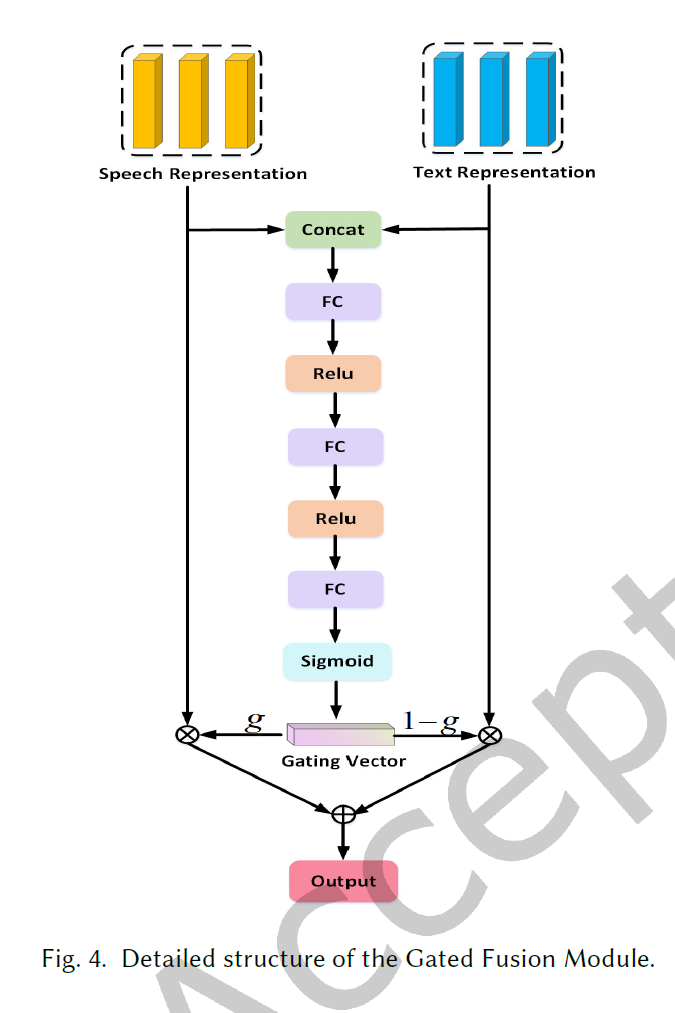

In [ ]:
class GatedFusion(nn.Module):
    def __init__(self, hidden_dim):
        super(GatedFusion, self).__init__()
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self.fc2 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, Et, Ea):
        #check the shape
        assert Et.shape == Ea.shape, "Et and Ea must have the same shape."

        concat = torch.cat((Et, Ea), dim=-1)  # [batch_size, seq_len, 2hidden_dim]

        out = self.fc1(concat)                # Shape: [batch_size, seq_len, 2hidden_dim]
        print(out.shape)
        out = self.relu(out)
        out = self.fc2(out)                   # Shape: [batch_size, seq_len, 2hidden_dim]
        print(out.shape)
        out = self.relu(out)
        out = self.fc3(out)                   # Shape: [batch_size, seq_len, hidden_dim]
        print(out.shape)
        out = self.relu(out)
        out = self.fc4(out)                   # Shape: [batch_size, seq_len, hidden_dim]
        print(out.shape)
        g = self.sigmoid(out)                 # Shape: [batch_size, seq_len, hidden_dim]

        # Compute the fused representation Ef
        Ef = g*Ea + (1-g)*Et           # Shape: [batch_size, seq_len, hidden_dim]

        return Ef

In [ ]:
hidden_dim = 768
gated_fusion = GatedFusion(hidden_dim=hidden_dim)
Ef = gated_fusion(output_text, output_audio)

torch.Size([10, 169, 1536])
torch.Size([10, 169, 1536])
torch.Size([10, 169, 768])
torch.Size([10, 169, 768])


In [ ]:
print(Ef.shape)
print(Ef)

torch.Size([10, 169, 768])
tensor([[[-0.2612, -0.1381, -0.2209,  ...,  0.1068,  0.1156, -0.4640],
         [-0.6774,  0.1985,  0.4808,  ...,  0.3764,  0.2262, -0.2735],
         [-0.7694,  0.2456,  0.3151,  ...,  0.5752, -0.1613, -0.3583],
         ...,
         [-0.0319,  0.3623, -0.3729,  ..., -0.0680, -0.3963,  0.2828],
         [-0.0319,  0.3623, -0.3729,  ..., -0.0680, -0.3963,  0.2828],
         [-0.0319,  0.3623, -0.3729,  ..., -0.0680, -0.3963,  0.2828]],

        [[-0.7775,  0.2505,  0.1643,  ..., -0.0603,  0.1094, -0.2743],
         [-0.6360,  0.1179, -0.0496,  ...,  0.1554,  0.2043, -0.3791],
         [-0.3038,  0.3195,  0.1930,  ...,  0.1173, -0.4719, -0.1364],
         ...,
         [-0.2676,  0.2114, -0.2159,  ..., -0.0645, -0.3690,  0.1016],
         [-0.2676,  0.2114, -0.2159,  ..., -0.0645, -0.3690,  0.1016],
         [-0.2676,  0.2114, -0.2159,  ..., -0.0645, -0.3690,  0.1016]],

        [[-0.0764,  0.3985,  0.4913,  ...,  0.4354, -0.1714, -0.0742],
         [-0.6262,

# BiFPN (alternative of Recurrent Pyramid Model)

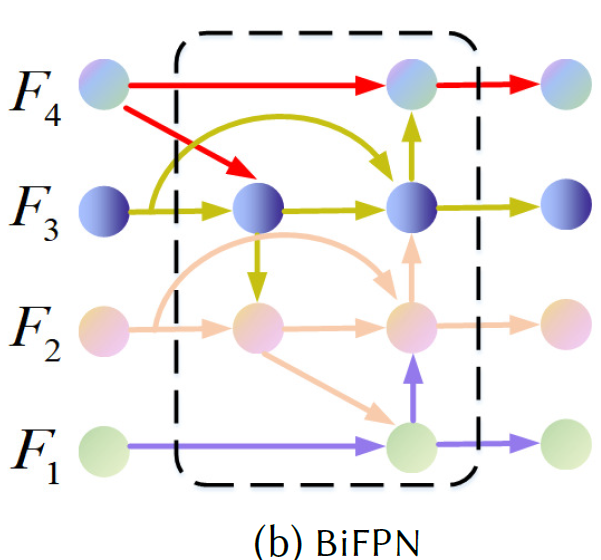

In [ ]:
class SeparableConvBlock(nn.Module):
    """
    A depthwise separable convolution block that consists of a depthwise convolution
    followed by a pointwise convolution, with batch normalization and activation.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, norm=True, activation=True):
        super(SeparableConvBlock, self).__init__()
        self.depthwise_conv = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels, bias=False)
        self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.norm = nn.BatchNorm1d(out_channels) if norm else None
        self.activation = nn.ReLU() if activation else None

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

class BiFPNLayer(nn.Module):
    """
    A single layer of BiFPN that performs bidirectional feature fusion.
    """
    def __init__(self, feature_size, epsilon=1e-4):
        super(BiFPNLayer, self).__init__()
        self.epsilon = epsilon

        # Weights for feature fusion
        self.w1 = nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)
        self.w3 = nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)

        # Convolution blocks
        self.conv3 = SeparableConvBlock(feature_size, feature_size)
        self.conv2 = SeparableConvBlock(feature_size, feature_size)
        self.conv1 = SeparableConvBlock(feature_size, feature_size)
        self.conv0 = SeparableConvBlock(feature_size, feature_size)

    def forward(self, p0, p1, p2, p3):
        """
        Args:
            p0, p1, p2, p3: Feature maps at different scales.
        Returns:
            Updated feature maps after bidirectional fusion.
        """

        w1 = F.relu(self.w1)
        w1 = w1 / (torch.sum(w1, dim=0) + self.epsilon)

        w2 = F.relu(self.w2)
        w2 = w2 / (torch.sum(w2, dim=0) + self.epsilon)

        w3 = F.relu(self.w3)
        w3 = w3 / (torch.sum(w3, dim=0) + self.epsilon)
        p3_td = p3

        p3_upsampled = F.interpolate(p3_td, size=p2.size(-1), mode='nearest')
        p2_td = self.conv2(w1[0] * p2 + w1[1] * p3_upsampled)

        p2_upsampled = F.interpolate(p2_td, size=p1.size(-1), mode='nearest')
        p1_td = self.conv1(w2[0] * p1 + w2[1] * p2_upsampled)

        p1_upsampled = F.interpolate(p1_td, size=p0.size(-1), mode='nearest')
        p0_td = self.conv0(w3[0] * p0 + w3[1] * p1_upsampled)

        # Bottom-up pathway
        # Downsample p0_td to match p1_td's sequence length
        p0_downsampled = F.interpolate(p0_td, size=p1_td.size(-1), mode='nearest')
        p1_out = self.conv1(w3[0] * p1_td + w3[1] * p0_downsampled)

        # Downsample p1_out to match p2_td's sequence length
        p1_downsampled = F.interpolate(p1_out, size=p2_td.size(-1), mode='nearest')
        p2_out = self.conv2(w2[0] * p2_td + w2[1] * p1_downsampled)

        # Downsample p2_out to match p3's sequence length
        p2_downsampled = F.interpolate(p2_out, size=p3.size(-1), mode='nearest')
        p3_out = self.conv3(w1[0] * p3 + w1[1] * p2_downsampled)

        return p0_td, p1_out, p2_out, p3_out


class BiFPN(nn.Module):
    """
    BiFPN module that can be stacked multiple times.
    """
    def __init__(self, feature_size=256, num_layers=1):
        super(BiFPN, self).__init__()
        self.num_layers = num_layers
        self.bifpn_layers = nn.ModuleList([BiFPNLayer(feature_size) for _ in range(num_layers)])

    def forward(self, features):
        """
        Args:
            features: List of feature maps [p0, p1, p2, p3] at different resolutions.
        Returns:
            List of enhanced feature maps at different resolutions.
        """
        p0, p1, p2, p3 = features

        for bifpn_layer in self.bifpn_layers:
            p0, p1, p2, p3 = bifpn_layer(p0, p1, p2, p3)
        print(p0.shape)

        return [p0, p1, p2, p3]

# Example usage
class MultimodalFeatureEnhancer(nn.Module):
    def __init__(self, input_dim, feature_size=256, num_bifpn_layers=2):
        super(MultimodalFeatureEnhancer, self).__init__()
        self.input_dim = input_dim
        self.feature_size = feature_size

        # Initial convolution to reduce dimensionality
        self.conv = nn.Conv1d(input_dim, feature_size, kernel_size=1)

        # Create feature maps at different scales using MaxPool
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # BiFPN
        self.bifpn = BiFPN(feature_size=feature_size, num_layers=num_bifpn_layers)

    def forward(self, x):
        """
        Args:
            x: Multimodal representation tensor of shape [batch_size, seq_len, input_dim]
        Returns:
            Enhanced feature representation.
        """
        # Transpose to [batch_size, input_dim, seq_len] for Conv1d
        x = x.transpose(1, 2)

        # Initial convolution
        p0 = self.conv(x)  # [batch_size, feature_size, seq_len]

        # Generate feature maps at different scales
        p1 = self.pool1(p0)
        p2 = self.pool2(p1)
        p3 = self.pool3(p2)

        # Apply BiFPN
        p0, p1, p2, p3 = self.bifpn([p0, p1, p2, p3])

        # Upsample and concatenate features
        p1_upsampled = F.interpolate(p1, size=p0.size(-1), mode='nearest')
        p2_upsampled = F.interpolate(p2, size=p0.size(-1), mode='nearest')
        p3_upsampled = F.interpolate(p3, size=p0.size(-1), mode='nearest')

        # Fuse features
        fused_features = p0 + p1_upsampled + p2_upsampled + p3_upsampled
        print(fused_features.shape)

        # Transpose back to [batch_size, seq_len, feature_size]
        fused_features = fused_features.transpose(1, 2)

        return fused_features

In [ ]:
enhancer = MultimodalFeatureEnhancer(768, 256, 2)
enhanced_features = enhancer(Ef)

torch.Size([10, 256, 169])
torch.Size([10, 256, 169])


In [ ]:
print(enhanced_features.shape)

torch.Size([10, 169, 256])


In [ ]:
print(enhanced_features)

tensor([[[0.3603, 2.8288, 2.2495,  ..., 3.6032, 0.3137, 5.9101],
         [2.8127, 1.9771, 0.9010,  ..., 2.3469, 0.3137, 6.6594],
         [1.8809, 1.8876, 0.9010,  ..., 2.3469, 0.3137, 6.5438],
         ...,
         [2.9743, 0.5957, 0.4998,  ..., 1.9544, 1.9153, 1.3009],
         [5.2078, 0.7545, 0.2383,  ..., 3.1715, 2.8257, 0.1243],
         [4.5438, 0.7545, 0.2383,  ..., 1.6581, 1.2463, 0.1243]],

        [[0.5775, 1.5946, 1.8539,  ..., 2.2678, 0.2885, 6.5705],
         [1.9302, 0.4068, 1.4391,  ..., 1.2080, 0.2885, 5.4702],
         [2.5697, 0.3496, 1.4391,  ..., 1.2080, 0.2885, 4.8957],
         ...,
         [1.7862, 0.8385, 1.3480,  ..., 3.3230, 1.9547, 3.0728],
         [4.1367, 0.8385, 0.6889,  ..., 4.3716, 2.1790, 1.6705],
         [4.1940, 0.8385, 0.5198,  ..., 1.6238, 1.6801, 1.6705]],

        [[0.0000, 0.4910, 1.7939,  ..., 0.7575, 0.9360, 4.9426],
         [1.3692, 0.4910, 1.5875,  ..., 0.0510, 0.9360, 4.8335],
         [1.5396, 1.0990, 1.5875,  ..., 0.0000, 0.9360, 5.

# BiFPN Update

In [ ]:
class SeparableConvBlock(nn.Module):
    """
    A depthwise separable convolution block that consists of a depthwise convolution
    followed by a pointwise convolution, with batch normalization and activation.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, norm=True, activation=True):
        super(SeparableConvBlock, self).__init__()
        self.depthwise_conv = nn.Conv1d(
            in_channels, in_channels, kernel_size=kernel_size,
            padding=padding, groups=in_channels, bias=False
        )
        self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.norm = nn.BatchNorm1d(out_channels) if norm else None
        self.activation = nn.ReLU() if activation else None

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

class BiFPNLayer(nn.Module):
    """
    A single layer of BiFPN that performs bidirectional feature fusion.
    """
    def __init__(self, feature_size, epsilon=1e-4):
        super(BiFPNLayer, self).__init__()
        self.epsilon = epsilon

        # Weights for top-down pathway
        self.w_p2_td = nn.Parameter(torch.ones(2), requires_grad=True)
        self.w_p1_td = nn.Parameter(torch.ones(2), requires_grad=True)
        self.w_p0_td = nn.Parameter(torch.ones(2), requires_grad=True)

        # Weights for bottom-up pathway
        self.w_p1_out = nn.Parameter(torch.ones(2), requires_grad=True)
        self.w_p2_out = nn.Parameter(torch.ones(2), requires_grad=True)
        self.w_p3_out = nn.Parameter(torch.ones(2), requires_grad=True)

        # Convolution blocks for each fusion node
        self.conv_p2_td = SeparableConvBlock(feature_size, feature_size)
        self.conv_p1_td = SeparableConvBlock(feature_size, feature_size)
        self.conv_p0_td = SeparableConvBlock(feature_size, feature_size)

        self.conv_p1_out = SeparableConvBlock(feature_size, feature_size)
        self.conv_p2_out = SeparableConvBlock(feature_size, feature_size)
        self.conv_p3_out = SeparableConvBlock(feature_size, feature_size)

    def forward(self, p0, p1, p2, p3):
        # Normalize weights for top-down pathway
        def normalize_weights(w):
            return F.relu(w) / (torch.sum(F.relu(w)) + self.epsilon)

        w_p2_td = normalize_weights(self.w_p2_td)
        w_p1_td = normalize_weights(self.w_p1_td)
        w_p0_td = normalize_weights(self.w_p0_td)

        # Top-down pathway
        p3_td = p3

        # Level p2_td
        p3_upsampled = F.interpolate(p3_td, size=p2.size(-1), mode='linear', align_corners=False)
        p2_td = w_p2_td[0] * p2 + w_p2_td[1] * p3_upsampled
        p2_td = self.conv_p2_td(p2_td)

        # Level p1_td
        p2_upsampled = F.interpolate(p2_td, size=p1.size(-1), mode='linear', align_corners=False)
        p1_td = w_p1_td[0] * p1 + w_p1_td[1] * p2_upsampled
        p1_td = self.conv_p1_td(p1_td)

        # Level p0_td
        p1_upsampled = F.interpolate(p1_td, size=p0.size(-1), mode='linear', align_corners=False)
        p0_td = w_p0_td[0] * p0 + w_p0_td[1] * p1_upsampled
        p0_td = self.conv_p0_td(p0_td)

        # Normalize weights for bottom-up pathway
        w_p1_out = normalize_weights(self.w_p1_out)
        w_p2_out = normalize_weights(self.w_p2_out)
        w_p3_out = normalize_weights(self.w_p3_out)

        # Bottom-up pathway
        # Level p1_out
        p0_downsampled = F.interpolate(p0_td, size=p1_td.size(-1), mode='linear', align_corners=False)
        p1_out = w_p1_out[0] * p1_td + w_p1_out[1] * p0_downsampled
        p1_out = self.conv_p1_out(p1_out)

        # Level p2_out
        p1_downsampled = F.interpolate(p1_out, size=p2_td.size(-1), mode='linear', align_corners=False)
        p2_out = w_p2_out[0] * p2_td + w_p2_out[1] * p1_downsampled
        p2_out = self.conv_p2_out(p2_out)

        # Level p3_out
        p2_downsampled = F.interpolate(p2_out, size=p3.size(-1), mode='linear', align_corners=False)
        p3_out = w_p3_out[0] * p3 + w_p3_out[1] * p2_downsampled
        p3_out = self.conv_p3_out(p3_out)

        return p0_td, p1_out, p2_out, p3_out

class BiFPN(nn.Module):
    """
    BiFPN module that can be stacked multiple times.
    """
    def __init__(self, feature_size=256, num_layers=1, epsilon=1e-4):
        super(BiFPN, self).__init__()
        self.num_layers = num_layers
        self.bifpn_layers = nn.ModuleList([
            BiFPNLayer(feature_size, epsilon) for _ in range(num_layers)
        ])

    def forward(self, features):
        p0, p1, p2, p3 = features

        for bifpn_layer in self.bifpn_layers:
            p0, p1, p2, p3 = bifpn_layer(p0, p1, p2, p3)

        return [p0, p1, p2, p3]

class MultimodalFeatureEnhancer(nn.Module):
    def __init__(self, input_dim, feature_size=256, num_bifpn_layers=2):
        super(MultimodalFeatureEnhancer, self).__init__()
        self.input_dim = input_dim
        self.feature_size = feature_size

        # Initial convolution to reduce dimensionality
        self.conv = nn.Conv1d(input_dim, feature_size, kernel_size=3, padding=1)

        # Create feature maps at different scales using strided convolutions
        self.conv_p1 = nn.Conv1d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)
        self.conv_p2 = nn.Conv1d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)
        self.conv_p3 = nn.Conv1d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

        # BiFPN
        self.bifpn = BiFPN(feature_size=feature_size, num_layers=num_bifpn_layers)

    def forward(self, x):
        # Transpose to [batch_size, input_dim, seq_len]
        x = x.transpose(1, 2)

        # Initial convolution
        p0 = self.conv(x)  # [batch_size, feature_size, seq_len]

        # Generate feature maps at different scales
        p1 = self.conv_p1(p0)
        p2 = self.conv_p2(p1)
        p3 = self.conv_p3(p2)

        # Apply BiFPN
        p0, p1, p2, p3 = self.bifpn([p0, p1, p2, p3])

        # Transpose each feature map back to [batch_size, seq_len, feature_size]
        p0 = p0.transpose(1, 2)
        p1 = p1.transpose(1, 2)
        p2 = p2.transpose(1, 2)
        p3 = p3.transpose(1, 2)

        # Return the multi-resolution features as a list or tuple
        return [p0, p1, p2, p3]



In [ ]:
mme = MultimodalFeatureEnhancer(768, 256, 2)
multi_res_features_list = mme(Ef)

In [ ]:
print(multi_res_features_list[0].shape)
print(multi_res_features_list[1].shape)
print(multi_res_features_list[2].shape)
print(multi_res_features_list[3].shape)

torch.Size([10, 169, 256])
torch.Size([10, 85, 256])
torch.Size([10, 43, 256])
torch.Size([10, 22, 256])


# BiFPN Update 2 (completed)

In [ ]:
class SeparableConvBlock(nn.Module):
    """
    A depthwise separable convolution block that consists of a depthwise convolution
    followed by a pointwise convolution, with batch normalization and activation.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, norm=True, activation=True):
        super(SeparableConvBlock, self).__init__()
        self.depthwise_conv = nn.Conv1d(
            in_channels, in_channels, kernel_size=kernel_size,
            padding=padding, groups=in_channels, bias=False
        )
        self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.norm = nn.BatchNorm1d(out_channels) if norm else None
        self.activation = nn.ReLU() if activation else None

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

In [ ]:
class BiFPNLayer(nn.Module):
    def __init__(self, feature_size):
        super(BiFPNLayer, self).__init__()

        # Convolution blocks for each fusion node in the top-down path
        self.conv_p2_td = SeparableConvBlock(feature_size, feature_size)
        self.conv_p1_td = SeparableConvBlock(feature_size, feature_size)
        self.conv_p0_td = SeparableConvBlock(feature_size, feature_size)

        # Convolution blocks for each fusion node in the bottom-up path
        self.conv_p0_out = SeparableConvBlock(feature_size, feature_size)
        self.conv_p1_out = SeparableConvBlock(feature_size, feature_size)
        self.conv_p2_out = SeparableConvBlock(feature_size, feature_size)

    def forward(self, p0, p1, p2):
        # Top-down pathway
        p2_td = self.conv_p2_td(p2)

        p2_upsampled = F.interpolate(p2_td, size=p1.size(-1), mode='linear', align_corners=False)
        p1_td = self.conv_p1_td(p1 + p2_upsampled)

        p1_upsampled = F.interpolate(p1_td, size=p0.size(-1), mode='linear', align_corners=False)
        p0_td = self.conv_p0_td(p0 + p1_upsampled)

        # Bottom-up pathway
        p0_downsampled = F.interpolate(p0_td, size=p1_td.size(-1), mode='linear', align_corners=False)
        p0_out = self.conv_p0_out(p0_downsampled + p1_td)

        p0_out_downsampled = F.interpolate(p0_out, size=p2_td.size(-1), mode='linear', align_corners=False)
        p1_out = self.conv_p1_out(p0_out_downsampled + p2_td)

        p1_out_downsampled = F.interpolate(p1_out, size=p2_td.size(-1), mode='linear', align_corners=False)
        p2_out = self.conv_p2_out(p1_out_downsampled + p2_td)

        return p0_td, p1_td, p2_td, p0_out, p1_out, p2_out


In [ ]:
class BiFPN(nn.Module):
    def __init__(self, feature_size=256, num_layers=1):
        super(BiFPN, self).__init__()
        self.num_layers = num_layers
        self.bifpn_layers = nn.ModuleList([
            BiFPNLayer(feature_size) for _ in range(num_layers)
        ])

    def forward(self, features):
        p0, p1, p2 = features

        for bifpn_layer in self.bifpn_layers:
            p0_td, p1_td, p2_td, p0_out, p1_out, p2_out = bifpn_layer(p0, p1, p2)
            # Update p0, p1, p2 for the next layer if stacking
            p0, p1, p2 = p0_td, p1_td, p2_td

        return [p0_td, p1_td, p2_td, p0_out, p1_out, p2_out]

In [ ]:
class MultimodalFeatureEnhancer(nn.Module):
    def __init__(self, input_dim, feature_size=256, num_bifpn_layers=2):
        super(MultimodalFeatureEnhancer, self).__init__()
        self.input_dim = input_dim
        self.feature_size = feature_size

        # First layer: 1D convolutional kernel of size 1
        self.conv = nn.Conv1d(input_dim, feature_size, kernel_size=1)

        # Second layer: 1D convolutional kernel of size 3, stride 2
        self.conv_p1 = nn.Conv1d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

        # Third layer: 1D convolutional kernel of size 3, stride 2
        self.conv_p2 = nn.Conv1d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

        # BiFPN
        self.bifpn = BiFPN(feature_size=feature_size, num_layers=num_bifpn_layers)

    def forward(self, x):
        # Transpose to [batch_size, input_dim, seq_len]
        x = x.transpose(1, 2)

        # First layer
        p0 = self.conv(x)  # [batch_size, feature_size, seq_len]

        # Second layer
        p1 = self.conv_p1(p0)

        # Third layer
        p2 = self.conv_p2(p1)

        # Apply BiFPN
        outputs = self.bifpn([p0, p1, p2])

        # Unpack outputs
        p0_td, p1_td, p2_td, p0_out, p1_out, p2_out = outputs

        # Transpose each feature map back to [batch_size, seq_len, feature_size]
        p0_td = p0_td.transpose(1, 2)
        p1_td = p1_td.transpose(1, 2)
        p2_td = p2_td.transpose(1, 2)
        p0_out = p0_out.transpose(1, 2)
        p1_out = p1_out.transpose(1, 2)
        p2_out = p2_out.transpose(1, 2)

        # Return the six feature maps
        return [p0_td, p1_td, p2_td, p0_out, p1_out, p2_out]

Top-Down Path Outputs:
- **p0_td**: Fine-grained feature map from the top-down path.
- **p1_td**: Medium-grained feature map from the top-down path.
- **p2_td**: Coarse-grained feature map from the top-down path.

Bottom-Up Path Outputs:
- **p0_out**: Fine-grained feature map from the bottom-up path.
- **p1_out**: Medium-grained feature map from the bottom-up path.
- **p2_out**: Coarse-grained feature map from the bottom-up path.


In [ ]:
bifpn = BiFPN(feature_size=256, num_layers=2)

In [ ]:
MFE = MultimodalFeatureEnhancer(input_dim=768, feature_size=256, num_bifpn_layers=2)

In [ ]:
outputs = mme(Ef)


In [ ]:
p0_td, p1_td, p2_td, p0_out, p1_out, p2_out = outputs
print("Shape of p0_td (top-down fine-grained):", p0_td.shape)  # [batch_size, seq_len, feature_size]
print("Shape of p1_td (top-down medium-grained):", p1_td.shape)  # [batch_size, seq_len//2, feature_size]
print("Shape of p2_td (top-down coarse-grained):", p2_td.shape)  # [batch_size, seq_len//4, feature_size]
print("Shape of p0_out (bottom-up fine-grained):", p0_out.shape)  # [batch_size, seq_len, feature_size]
print("Shape of p1_out (bottom-up medium-grained):", p1_out.shape)  # [batch_size, seq_len//2, feature_size]
print("Shape of p2_out (bottom-up coarse-grained):", p2_out.shape)  # [batch_size, seq_len//4, feature_size]

Shape of p0_td (top-down fine-grained): torch.Size([10, 169, 256])
Shape of p1_td (top-down medium-grained): torch.Size([10, 85, 256])
Shape of p2_td (top-down coarse-grained): torch.Size([10, 43, 256])
Shape of p0_out (bottom-up fine-grained): torch.Size([10, 85, 256])
Shape of p1_out (bottom-up medium-grained): torch.Size([10, 43, 256])
Shape of p2_out (bottom-up coarse-grained): torch.Size([10, 43, 256])


# Adaptive Fusion Module (completed)

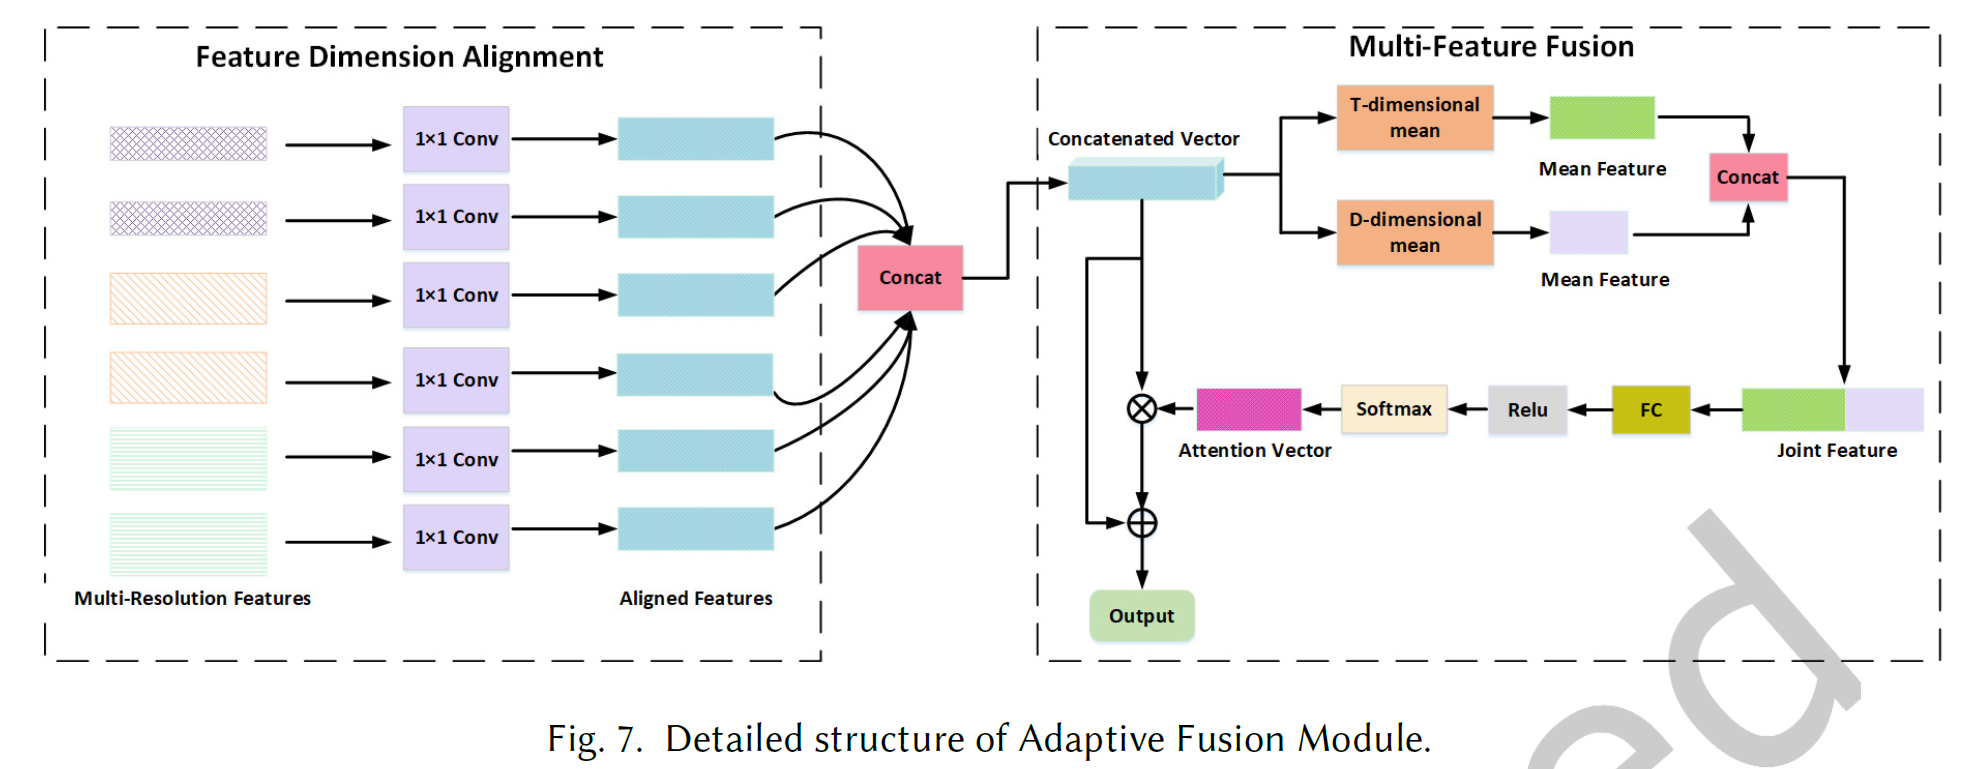

In [ ]:
class FeatureAlignment(nn.Module):
    """
    Aligns features from different resolutions to the same temporal dimension using 1D convolutions.
    """
    def __init__(self, feature_dim):
        super(FeatureAlignment, self).__init__()
        # Create 1D convolution layers for each feature map to align temporal dimensions
        self.align_convs = nn.ModuleList([
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1)
            for _ in range(6)
        ])

    def forward(self, features):
        """
        Args:
            features: List of 6 feature maps, each of shape [B, T_i, D]
        Returns:
            H: Tensor of shape [B, 6, D, T], where T is the aligned temporal dimension
        """
        # Initialize list to hold aligned features
        aligned_features = []
        # Find the maximum temporal length among all feature maps
        max_len = max(f.shape[1] for f in features)
        for i, f in enumerate(features):
            # f: [B, T_i, D]
            # Transpose to [B, D, T_i] for Conv1d
            f = f.transpose(1, 2)  # [B, D, T_i]
            # Align feature using 1D convolution
            f_aligned = self.align_convs[i](f)  # [B, D, T_i]
            # Upsample or downsample to max_len
            if f_aligned.shape[2] != max_len:
                f_aligned = F.interpolate(f_aligned, size=max_len, mode='linear', align_corners=False)
            aligned_features.append(f_aligned)
        # Stack features along a new dimension (feature index)
        # Resulting shape: [B, 6, D, T]
        H = torch.stack(aligned_features, dim=1)  # [B, 6, D, T]
        return H  # [B, 6, D, T]

class MultiFeatureFusion(nn.Module):
    """
    Fuses aligned features using an adaptive attention mechanism based on channel attention.
    """
    def __init__(self, feature_dim):
        super(MultiFeatureFusion, self).__init__()
        # Fully connected layer for attention mechanism
        self.attention_fc = nn.Linear(12, 6)  # Input dimension is 2 * feature_dim (after concatenation)
        # ReLU activation
        self.relu = nn.ReLU()
        # Softmax for attention weights
        self.softmax = nn.Softmax(dim=1)  # Over the 6 feature maps

    def forward(self, H):
        """
        Args:
            H: Tensor of shape [B, 6, D, T]
        Returns:
            fused_features: Tensor of shape [B, T, D], the final fused output
        """
        B, N, D, T = H.shape  # N = 6
        # Compute mean over T dimension: [B, N, D]
        mean_T = H.mean(dim=3)  # [B, 6, D]
        # Compute mean over D dimension: [B, N, T]
        mean_D = H.mean(dim=2)  # [B, 6, T]
        # Compute global mean over D of mean_T to get scalar per feature map
        mean_TD = mean_T.mean(dim=2)  # [B, 6]
        # Compute global mean over T of mean_D to get scalar per feature map
        mean_DT = mean_D.mean(dim=2)  # [B, 6]
        # Concatenate mean_TD and mean_DT along feature dimension
        mean_features = torch.cat([mean_TD, mean_DT], dim=1)  # [B, 12]
        # Pass mean_features through attention_fc
        attention_scores = self.attention_fc(mean_features)  # [B, 6]
        # Apply ReLU activation
        attention_scores = self.relu(attention_scores)  # [B, 6]
        # Apply Softmax to get attention weights
        attention_weights = self.softmax(attention_scores)  # [B, 6]
        # Reshape attention_weights to [B, 6, 1, 1] for broadcasting
        attention_weights = attention_weights.unsqueeze(-1).unsqueeze(-1)  # [B, 6, 1, 1]
        # Apply attention weights to H
        weighted_H = H * attention_weights  # [B, 6, D, T]
        # Sum over the feature map dimension to fuse features
        fused_features = weighted_H.sum(dim=1)  # [B, D, T]
        # Add residual connection (e.g., sum with mean over feature maps)
        residual = H.mean(dim=1)  # [B, D, T]
        fused_features = fused_features + residual  # [B, D, T]
        # Transpose to [B, T, D]
        fused_features = fused_features.transpose(1, 2)  # [B, T, D]
        return fused_features  # [B, T, D]

class AdaptiveFusionModule(nn.Module):
    """
    Combines the FeatureAlignment and MultiFeatureFusion modules to perform adaptive fusion of features.
    """
    def __init__(self, feature_dim):
        super(AdaptiveFusionModule, self).__init__()
        self.feature_alignment = FeatureAlignment(feature_dim)
        self.feature_fusion = MultiFeatureFusion(feature_dim)

    def forward(self, features):
        """
        Args:
            features: List of 6 feature maps, each of shape [B, T_i, D]
        Returns:
            fused_output: Tensor of shape [B, T, D], the final fused representation
        """
        # Step 1: Align features in the temporal dimension
        H = self.feature_alignment(features)  # [B, 6, D, T]
        # Step 2: Fuse features using attention mechanism
        fused_output = self.feature_fusion(H)  # [B, T, D]
        return fused_output

In [ ]:
afm = AdaptiveFusionModule(256)

In [ ]:
fused_output = afm(outputs)

In [ ]:
print("Shape of fused output:", fused_output.shape)

Shape of fused output: torch.Size([10, 169, 256])


# Overall Network